# Онлайн алгоритмы в задаче формирования портфеля ценных бумаг

## Постановка задачи

В задаче формирования портфеля ценных бумаг допустимыми решениями являются всевозможные распределения состояния, имеющегося у игрока, т.е. элементы стандартного симплекса:

$$
\Delta_d = \left\{
x \in \mathbb{R}^d
:\;
\sum_{i = 1}^d x_i = 1,
\;
x_i \geq 0
\right\}.
$$

Противник (природа) независимо выбирает рыночную доходность активов,
т.е. вектор $r_t \in \mathbb{R}_+^d$,
у которого $i$-ая компонента определяется формулой

$$
[r_t]_i = \frac{\text{цена единицы $i$-го актива в момент } t + 1}{\text{цена единицы $i$-го актива в момент } t}.
$$

*Цель игрока* — максимизировать свое состояние по проишествии $T$ раундов, которая эквивалентна максимизации величины

$$
\sum_{t=1}^T \log r_t^\top x_t,
$$

которую будем называть *логарифмическим приростом* портфеля ценных бумаг к моменту времени $T$.

Регрет алгоритма $\mathcal{A}$ к раунду $T$ определяется формулой

$$
\mathrm{regret}_T(\mathcal{A})
=
\sum_{t=1}^T f_t(x_t)
-
\min_{x \in \Delta_d}
\sum_{t = 1}^T f_t(x),
$$

где $f_t(x) = -\log r_t^\top x$.

В этом задании вам предстоит реализовать алгоритмического инвестора на основе онлайн градиентного спуска, принимающего решения о перераспределении имеющихся средств между акциями российского фондового рынка:
- в момент времени $t$ алгоритм должен предложить распределение средств между активами $x_t$;
- после этого алгоритму открывается вектор рыночных доходностей $r_t$ из истории наблюдений;
- алгоритм должен использовать поступившую информацию для корректировки и принятия решения на следующей итерации.

## Подготовка данных (3 балла)

Загрузите котировки (сформируйте набор данных) акций `RASP`, `GAZP`, `DSKY`, `SBER`, `KMAZ`, `RUAL` c 01.04.2020 по 22.04.2022 с интервалом в один день (раунд игры = день). Выведите таблицу (`pd.DataFrame`), в которой столбцы содержат временные ряды для каждого тикера, а их названия — тикеры. **[1 балл]**

In [131]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [132]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from numpy.typing import ArrayLike

In [133]:
# загрузка и подготовка данных
tickers = ['RASP.ME', 'GAZP.ME', 'DSKY.ME', 'SBER.ME', 'KMAZ.ME', 'RUAL.ME']
data = pd.DataFrame(columns=tickers)
data = yf.download(tickers,'2020-04-01','2022-04-22')['Adj Close']

display(data)

[*********************100%***********************]  6 of 6 completed


,DSKY.ME,GAZP.ME,KMAZ.ME,RASP.ME,RUAL.ME,SBER.ME
Date,,,,,,
2020-04-01,76.164963,158.852737,50.642338,80.271111,24.754999,131.187042
2020-04-02,76.587540,165.010651,50.245144,81.617714,24.955000,132.727661
2020-04-03,79.799095,167.419113,53.224102,81.371384,24.830000,131.797623
2020-04-06,82.655716,168.592468,54.018497,82.865799,25.754999,135.390030
2020-04-07,82.926163,168.698334,54.217091,81.272842,26.049999,140.310074
...,...,...,...,...,...,...
2022-04-15,77.720001,224.000000,100.099998,398.600006,66.750000,130.880005
2022-04-18,75.599998,216.990005,100.099998,403.149994,64.605003,123.849998
2022-04-19,75.199997,220.720001,99.300003,391.149994,63.200001,120.300003


Визуализируйте поведение всех тикеров на всём горизонте игры. **[1 балл]**

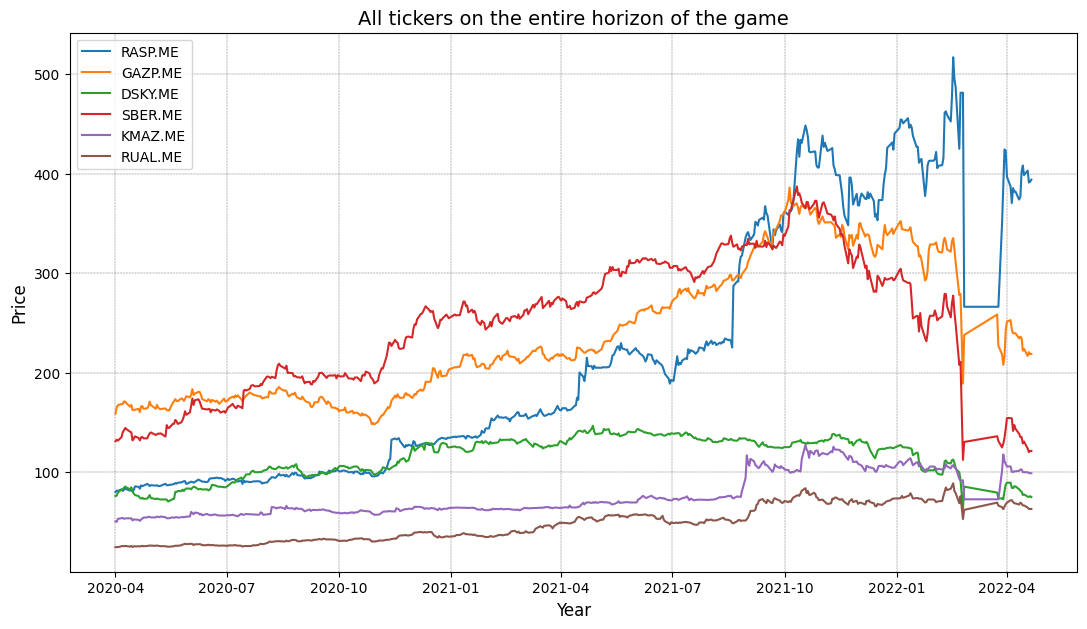

In [134]:
# красивая визуализация на графике с подписями и адекватным масштабом
plt.figure(figsize=(13,7))
for ticker in tickers:
    plt.plot(data.index, data[ticker], label=ticker)

plt.legend(loc='upper left')

plt.title("All tickers on the entire horizon of the game", fontsize=14)

plt.ylabel('Price', fontsize=12)
plt.xlabel('Year', fontsize=12)

plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
plt.show()

Постройте таблицу (с тем же заголовком), содержащую по столбцам временные ряды *рыночных доходностей* тикеров. **[1 балл]**


In [135]:
# расчет рыночных доходностей
returns = data.pct_change().dropna()

returns.columns = [col for col in returns.columns]

print("All tickers on the entire horizon of the game")
display(returns.abs())

All tickers on the entire horizon of the game


,DSKY.ME,GAZP.ME,KMAZ.ME,RASP.ME,RUAL.ME,SBER.ME
Date,,,,,,
2020-04-02,0.005548,0.038765,0.007843,0.016776,0.008079,0.011744
2020-04-03,0.041933,0.014596,0.059288,0.003018,0.005009,0.007007
2020-04-06,0.035798,0.007008,0.014925,0.018365,0.037253,0.027257
2020-04-07,0.003272,0.000628,0.003676,0.019223,0.011454,0.036340
2020-04-08,0.019160,0.015113,0.016483,0.017175,0.011516,0.013460
...,...,...,...,...,...,...
2022-04-15,0.006214,0.008509,0.001994,0.023398,0.001500,0.014181
2022-04-18,0.027277,0.031295,0.000000,0.011415,0.032135,0.053713
2022-04-19,0.005291,0.017190,0.007992,0.029766,0.021748,0.028664


## Онлайн градиентный спуск (8 баллов)

Приведите выражение для градиента функции $f_t(x)$ и запишите явную формулу для итерации OGD. **[1 балл]**

Градиент функции $f_t(x) = -\log r_t^\top x$ выглядит следующим образом:
$$\nabla f_t(x) = \frac{r_t}{r_t^\top x}$$

Явная формула для итерации OGD:
$$x_{t+1} = \text{proj}_{\Delta_d} (x_t - \eta_t \nabla f_t(x_t))$$
где $\eta_t$ - длина шага (learning rate), $\text{proj}_{\Delta_d}$ - проекция на стандартный симплекс $\Delta_d$.

Реализуйте инвестора, принимающего решение на основе итераций онлайн градиентного спуска. **[4 балла]**

Используйте готовую функцию `simplex_projection`, проектирующую входной вектор на стандартный симплекс.

In [136]:
def _unsafe_simplex_projection(s: ArrayLike, norm_constraint: float) -> ArrayLike:
    """Находит проекцию на симплекс."""
    u = np.sort(s)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, len(u) + 1) > (cssv - norm_constraint))[0][-1]
    theta = (cssv[rho] - norm_constraint) / (rho + 1.0)
    return np.maximum(s - theta, 0)


def simplex_projection(s: ArrayLike):
    """Возвращает проекцию на единичный симплекс."""
    return s if np.sum(s) == 1 else _unsafe_simplex_projection(s, 1.0)

In [137]:
# реализация онлайн градиентного спуска
def OGD(data, learning_rate=0.01):
    n = len(data.columns)
    m = len(data)
    x = np.ones(n) / n
    portfolio_value = [1]
    for t in range(1, m):
        gradient = data.iloc[t].values / np.dot(x, data.iloc[t].values) - np.dot(x, np.divide(data.iloc[t].values, np.dot(x, data.iloc[t].values)))
        x = simplex_projection(x + learning_rate * gradient)
        portfolio_value.append(np.exp(np.log(np.dot(x, data.iloc[t].values)) - np.log(np.dot(x, data.iloc[t-1].values))))
    return portfolio_value
    

### Запуск OGD

Как будете выбирать шаг при запуске OGD? Приведите исчерпывающее объяснение и мотивацию. **[1 балл]**

Выбор шага при запуске OGD может оказаться критически важным для эффективности метода оптимизации. В общем случае, для выбора шага можно использовать техники линейного поиска или оптимизации на каждой итерации, но такой подход может быть вычислительно затратным.

Более распространенным подходом является выбор константного шага $\eta$, который удовлетворяет определенным условиям, таким как условия на гладкость функции или на ее липшицевость. Для функции $f_t(x)$ в формуле OGD обычно используется ограничение Липшица, то есть существует константа $L$ такая, что для любых $x,y$:

$$
\|\nabla f_t(x) - \nabla f_t(y)\| \leq L\|x-y\|.
$$

Для этой функции можно выбрать шаг вида $\eta_t = \frac{1}{L\sqrt{t}}$, где $t$ - номер итерации. Этот шаг гарантирует сходимость метода и определенную скорость сходимости.

При использовании OGD в задаче формирования портфеля ценных бумаг можно выбирать шаг аналогично тому, как это делается в других задачах. В частности, на практике распространены следующие стратегии выбора шага:

1. Константный шаг: Фиксируется значение $\eta > 0$ и используется для всех итераций. Простой в реализации, но может приводить к неоптимальным результатам при различных видах функций потерь.

2. Убывающий шаг: Значение шага $\eta_t$ на итерации $t$ зависит от номера итерации $t$. Например, можно использовать $\eta_t = \frac{1}{\sqrt{t}}$ или $\eta_t = \frac{1}{t}$, что гарантирует сходимость алгоритма при некоторых дополнительных условиях на функцию потерь.

3. Линейный шаг: Шаг выбирается как $\eta_t = \frac{\eta_0}{\sqrt{t}}$, где $\eta_0$ - начальное значение шага. При этом можно использовать параметр $\eta_0$ для настройки скорости сходимости.

4. Адаптивный шаг: Значение шага на каждой итерации выбирается исходя из значения градиента. Одним из популярных методов выбора шага является Adagrad, который адаптирует шаг под каждую компоненту градиента функции потерь. Однако такой подход может приводить к слишком малым шагам в долгосрочной перспективе, что затрудняет нахождение оптимального решения.

Для задачи формирования портфеля ценных бумаг можно использовать как константный, так и убывающий шаг, а также экспериментально подобрать наилучшую стратегию выбора шага для данного набора данных.

Начиная с равномерного распределения состояния между активами, запустите OGD на всём горизонте игры. Визуализируйте динамику логарифмического прироста портфеля ценных бумаг за весь период для OGD и инвестора, зафиксировавшего своё (произвольное) распределение в начале игры. **[2 балла]**

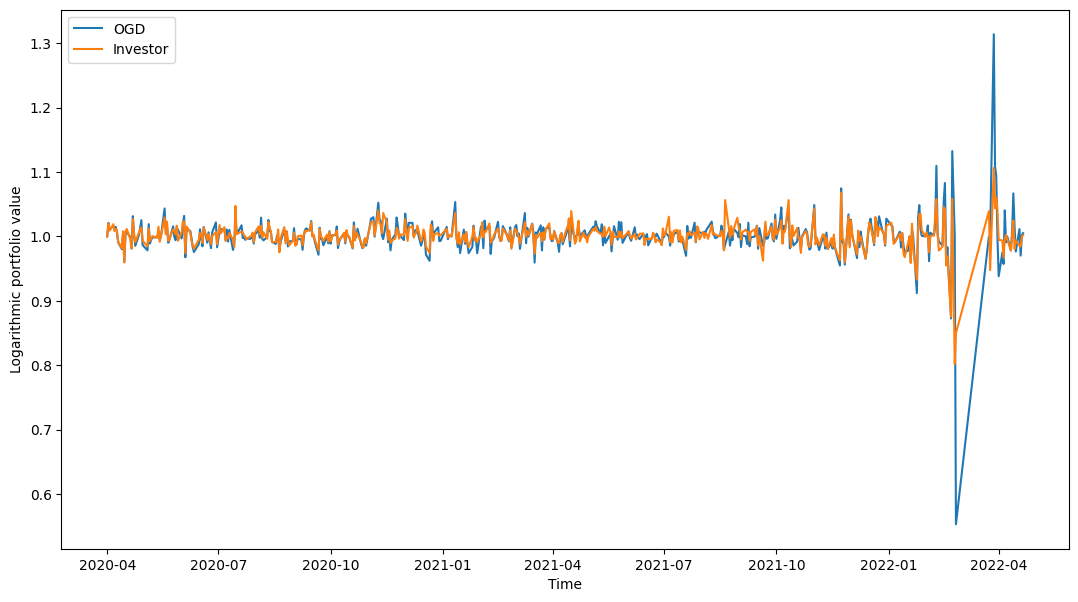

In [138]:
initial_weights = np.array([0.1, 0.2, 0.1, 0.2, 0.2, 0.2])

# Запускаем OGD на всём горизонте игры с произвольным начальным распределением инвестиций
ogd_portfolio_value = OGD(data, learning_rate=0.1)
# Запускаем инвестора, зафиксировавшего своё произвольное распределение в начале игры
investor_portfolio_value = [1]
for t in range(1, len(data)):
    investor_portfolio_value.append(np.exp(np.log(np.dot(initial_weights, data.iloc[t].values)) - np.log(np.dot(initial_weights, data.iloc[t-1].values))))

# Визуализируем динамику логарифмического прироста портфеля ценных бумаг за весь период
plt.figure(figsize=(13,7))
plt.plot(data.index[0:], ogd_portfolio_value, label='OGD')
plt.plot(data.index[0:], investor_portfolio_value, label='Investor')
plt.xlabel('Time')
plt.ylabel('Logarithmic portfolio value')
plt.legend()
plt.show()

## Дополнительное задание (4 балла)

Реализуйте любой подходящий канонический онлайн алгоритм из курса или даже их композицию. Визуализируйте динамику логарифмического прироста портфеля ценных бумаг за весь период для OGD и инвестора, принимающего решения на основе выбранного алгоритма. Сравните итоговые распределения, полученные с помощью этих алгоритмов, и попробуйте сделать выводы.

In [139]:
def exp_weighted_majority(predictions, weights, eta):
    w = weights * np.exp(eta * predictions)
    return w / np.sum(w)


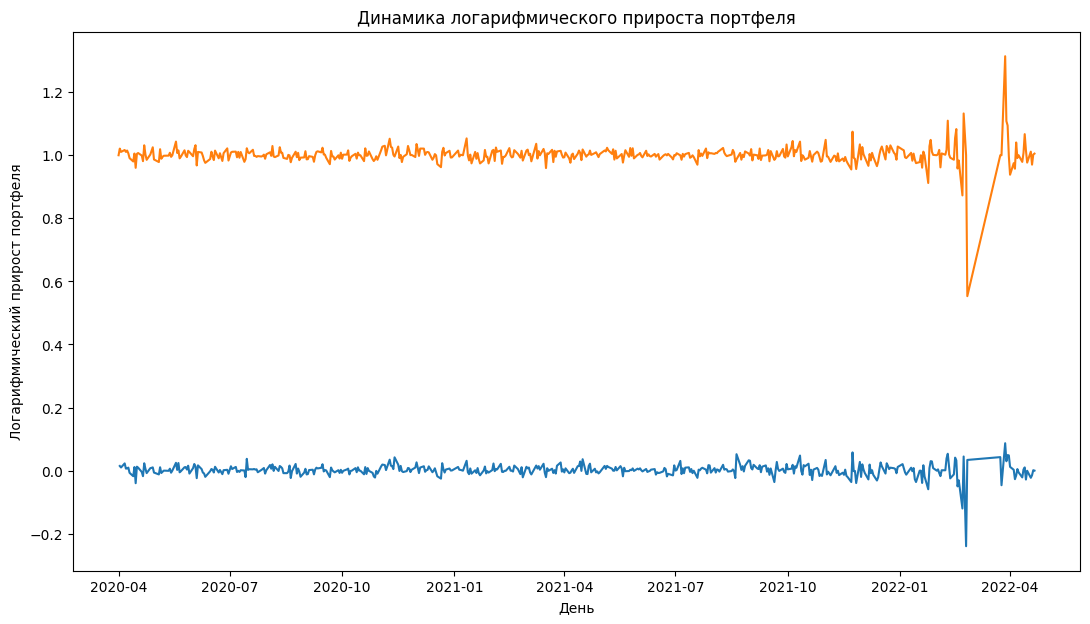

In [140]:
# Вычисляем процентный прирост цен акций и записываем в новый датафрейм
returns = data.pct_change().dropna()

# Задаем начальные веса
initial_weights = np.array([0.1, 0.2, 0.1, 0.2, 0.2, 0.2])
weights = initial_weights.copy()

# Создаем список для сохранения логарифмического прироста портфеля
portfolio_returns = []

# Применяем алгоритм экспоненциального взвешивания для каждого дня и сохраняем результаты
for i in range(len(returns)):
    predictions = returns.iloc[i]
    weights = exp_weighted_majority(predictions, weights, eta=0.1)
    portfolio_return = np.dot(weights, returns.iloc[i])
    portfolio_returns.append(portfolio_return)

# Визуализируем динамику логарифмического прироста портфеля за весь период
plt.figure(figsize=(13,7))
plt.plot(data.index[1:], portfolio_returns, label='Investor')
plt.plot(data.index[0:], ogd_portfolio_value, label='OGD')
plt.title('Динамика логарифмического прироста портфеля')
plt.xlabel('День')
plt.ylabel('Логарифмический прирост портфеля')
plt.show()